## SampleStreetNetwork

This script:
- Samples points along the road network at approximately 200 metres spacing
- Downloads images from Google Street View via the Maps API
- Captures four images per location, facing the four cardinal directions
- Saves a pickled dataset containing:
     - Point coordinates
     - Image metadata
     - Filepaths to all downloaded images

In [4]:
import os
import random
import pickle
import geopandas as gpd
from shapely.geometry import Point, LineString
import osmnx as ox
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# ----------------- Configuration -----------------
np.random.seed(42)
density_per_km = 0.3  # number of points to sample per km of road (set to 0.1 while testing)
DOWNLOAD_IMAGES = False  # If false then don't download any images, just load those that have been cached

sample_spacing = 200.0   # distance in meters between sample points on roads (set to 5000 for testing)
n_directions = 4         # number of street view images per point (e.g., 4 cardinal directions)
image_size = "640x640"   # requested image resolution from Street View API

In [ ]:
from directory_filepaths import *
boundary_file = os.path.join(data_dir, "greater_manchester_lsoas.geojson")  # Path to boundary polygon file

## Load neighbourhood polygons and dissolve to one study-area boundary

In [6]:
boundary_neighs = gpd.read_file(boundary_file)
# Make sure we're in WGS84 (lat/lon) for OSM and APIs
boundary_neighs = boundary_neighs.to_crs(epsg=4326)
# Dissolve: merge all geometries into one polygon (MultiPolygon possible)
boundary_polygon = boundary_neighs.union_all() # shapely (multi)polygon
boundary_gdf = gpd.GeoDataFrame(data={'name': ['study_area']},
    geometry=[boundary_polygon], crs=boundary_neighs.crs)
print("Merged neighbourhoods into single study-area boundary.")
print("Bounds:", boundary_polygon.bounds)
# boundary_gdf.plot(color='lightblue', edgecolor='black')

Merged neighbourhoods into single study-area boundary.
Bounds: (-2.73052481406758, 53.3281053809015, -1.90962093258169, 53.6857339236763)


## Get Road Network for the Area from OSM

In [7]:
# Get (or cache) the road network with OSMnx’s built-in GraphML I/O
# --------------------------------------------------------------------
# Tell OSMnx to keep all cache files inside the project folder (optional)
#ox.settings.cache_folder = str(data_dir / "osmnx_http_cache")  # HTTP/tile cache
#ox.settings.use_cache = True  # default is True
ox.settings.use_cache = False      # <- prevents the “cache” dir being written

graph_file = data_dir + "sample_points_cache/road_network.graphml"  # one self-contained file

if os.path.isfile(graph_file):
    print("Loading road network from GraphML cache …")
    road_graph = ox.load_graphml(graph_file)
else:
    print("Downloading road network from OSM …")
    road_graph = ox.graph_from_polygon(boundary_polygon, network_type="drive")
    ox.save_graphml(road_graph, graph_file)
    print(f"Graph saved to {graph_file}")

# Convert to GeoDataFrame of edges for downstream sampling/plotting
edges_gdf = ox.graph_to_gdfs(road_graph, nodes=False)

print(f"Number of road segments: {len(edges_gdf)}")

Loading road network from GraphML cache …
Number of road segments: 232675


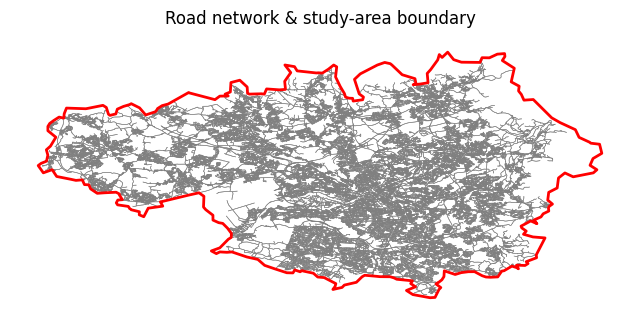

In [8]:
fig, ax = plt.subplots(figsize=(8, 8))

# Plot roads first (thin gray lines)
edges_gdf.plot(ax=ax, linewidth=0.4, color="gray")

# Plot the study-area outline on top (thicker red line)
boundary_gdf.boundary.plot(ax=ax, linewidth=2, edgecolor="red")

ax.set_title("Road network & study-area boundary", pad=12)
ax.set_axis_off()          # hides lat/lon ticks for a cleaner look
ax.set_aspect("equal")     # keeps the map from looking stretched

plt.show()

### Generate a sample of points along the road network and plot them

In [ ]:
def generate_sample_points(min_points_per_edge, max_points_per_edge, boundary_gdf, edges_gdf):
    # --------------------------------------------------------------------
    # Generate a sample of points along the street network (probabilistic)
    # --------------------------------------------------------------------

    # Re-project roads to a metric CRS for length calculations
    utm_crs = boundary_gdf.estimate_utm_crs()
    edges_proj = edges_gdf.to_crs(utm_crs)

    samples = []

    # Loop over every edge geometry
    for geom in edges_proj.geometry:
        if geom is None or geom.length == 0:
            continue

        length_m = geom.length
        expected = length_m / 1000 * density_per_km  # λ for Poisson
        n_points = np.random.poisson(expected)  # 0, 1, 2, …

        # Clip to limits
        n_points = max(min_points_per_edge, min(n_points, max_points_per_edge))

        if n_points == 0:
            continue

        # Evenly distribute interior points (skip endpoints)
        distances = np.linspace(0, length_m, n_points + 2)[1:-1]
        for d in distances:
            samples.append(geom.interpolate(d))

    # Build GeoDataFrame of sample points (back to WGS-84 for API use)
    points_gdf = (gpd.GeoDataFrame(geometry=gpd.GeoSeries(samples), crs=utm_crs)
        .to_crs(epsg=4326))
    points_gdf["lon"] = points_gdf.geometry.x.round(6)
    points_gdf["lat"] = points_gdf.geometry.y.round(6)
    points_gdf = points_gdf.drop_duplicates(subset=["lat", "lon"]).reset_index(drop=True)

    print( f"Generated {len(points_gdf)} points "
        f"with expected density {density_per_km} pts/km.")

In [9]:
if DOWNLOAD_IMAGES:
    min_points_per_edge = 0
    max_points_per_edge = 10
    generate_sample_points(min_points_per_edge, max_points_per_edge, boundary_gdf, edges_gdf)
else:
    print("DOWNLOAD_IMAGES is false, so not sampling from the road network")
    
if DOWNLOAD_IMAGES:
    fig, ax = plt.subplots(figsize=(8, 8))

    # Plot roads first (thin gray lines)
    edges_gdf.plot(ax=ax, linewidth=0.4, color="gray")

    # Plot the sample points
    points_gdf.plot(ax=ax, color="blue", markersize=2, label="Sample Points")

    # Plot the study-area outline on top (thicker red line)
    boundary_gdf.boundary.plot(ax=ax, linewidth=2, edgecolor="red")

    ax.set_title("Road network & study-area boundary", pad=12)
    ax.set_axis_off()          # hides lat/lon ticks for a cleaner look
    ax.set_aspect("equal")     # keeps the map from looking stretched

    plt.show()    

DOWNLOAD_IMAGES is false, so not sampling from the road network


## Download street view images for each point

Note: expects a valid Google Maps API key in the file `google_maps_api_key.txt` in the same directory as this script (not synced to github for obvious reasons).

In [10]:
# Get the API key from a file (of needed)
if DOWNLOAD_IMAGES:
    with open('google_maps_api_key.txt', 'r') as f:
        api_key = f.readline().strip()

A load of images were downloaded incorrectly (just got a streetview blank jpeg not a proper image). The following code identifies the first image that went wrong (I found that it was image 8116 by looking at the saved picture files) and removes it and all other from the point records. Then I delete the corresponding images. Hopefully this removed the bad images and kept the point cache and images aligned.

In [ ]:
#with open(points_data_cache, "rb") as f:
#    point_records = pickle.load(f)
#
#point_records_bak = point_records.copy()
#index = next(i for i, d in enumerate(point_records) if d['point_id'] == 19196)
#print(index)
#point_records[index]  # This is the index of the record identified above
#
#point_records = point_records[:index]
#
#point_records[18895]
#
#with open(points_data_cache, "wb") as f:
#    pickle.dump(point_records, f)

### Not sure what this does

In [15]:
# Cache file for the entire points data with embeddings (images are stored separately)
DEBUG = False
points_data_cache = data_dir + "sample_points_cache/points_data_cache.pkl"

# -----------------------------------------------------------
# Load existing cache so we can *append* new sample points
# -----------------------------------------------------------
if os.path.isfile(points_data_cache):
    print("Loading cached point data …")
    with open(points_data_cache, "rb") as f:
        point_records = pickle.load(f)
    existing_coords = {(rec["latitude"], rec["longitude"]) for rec in point_records}
    next_id = max(rec["point_id"] for rec in point_records) + 1
else:
    print("create")
    point_records = []
    existing_coords = set()
    next_id = 0

print(f"Cache currently has {len(point_records)} points.")
added_this_run = 0

# -----------------------------------------------------------
# Iterate through newly‑sampled street‑network points (with a progress bar)
# -----------------------------------------------------------
if DOWNLOAD_IMAGES:
    for _, row in tqdm(points_gdf.iterrows(), total=len(points_gdf), desc="Downloading images"):
        lat = row["lat"]
        lon = row["lon"]

        # Skip if imagery for this coordinate (rounded earlier) already exists
        if (lat, lon) in existing_coords:
            continue

        point_id = next_id
        next_id += 1
        added_this_run += 1

        # ---- Street‑View metadata ----
        meta_params = {"location": f"{lat},{lon}", "key": api_key}
        meta_url = "https://maps.googleapis.com/maps/api/streetview/metadata"
        try:
            meta = requests.get(meta_url, params=meta_params).json()
        except Exception as e:
            print(f"[Point {point_id}] Metadata request failed: {e}")
            continue

        if meta.get("status") != "OK":
            if DEBUG:
                print(f"[Point {point_id}] Street View not available (status={meta.get('status')}).")
            continue

        pano_id = meta.get("pano_id")
        date = meta.get("date")  # e.g. "2024‑08"

        # ---- Download images for the specified headings ----
        point_image_files = []
        for heading in np.linspace(0, 360, num=n_directions, endpoint=False):
            fname = f"point{point_id}_heading{int(heading)}.jpg"
            print(fname)
            image_path = image_dir / fname
            point_image_files.append(str(image_path))

            if image_path.exists():
                continue  # already on disk

            img_params = {
                "size": image_size,
                "pano": pano_id,
                "heading": str(int(heading)),
                "pitch": "0",
                "key": api_key,
            }
            img_url = "https://maps.googleapis.com/maps/api/streetview"
            try:
                img_resp = requests.get(img_url, params=img_params)
                with open(image_path, "wb") as f:
                    f.write(img_resp.content)
            except Exception as e:
                print(f"Failed to download image for point {point_id}, heading {heading}: {e}")

        # ---- Append the new record ----
        point_records.append(
            {
                "point_id": point_id,
                "latitude": lat,
                "longitude": lon,
                "date": date,
                "image_files": point_image_files,
                "embedding": None,  # to be filled later
            })
        existing_coords.add((lat, lon))

    print(f"Added {added_this_run} new points this run (total now {len(point_records)}).")

    # Persist the (possibly) updated cache immediately
    with open(points_data_cache, "wb") as f:
        pickle.dump(point_records, f)

else:
    print("DOWNLOAD_IMAGES set to false, so not downloading any images")

Loading cached point data …
Cache currently has 18897 points.
DOWNLOAD_IMAGES set to false, so not downloading any images


### Map of the full sample (cache + any others just downlaoded)

In [12]:
if point_records:    
    fig, ax = plt.subplots(figsize=(8, 8))

    # Plot roads first (thin gray lines)
    edges_gdf.plot(ax=ax, linewidth=0.1, color="gray")

    # Plot the sample points
    gpd.GeoDataFrame(point_records, 
                     geometry=[Point(rec["longitude"], rec["latitude"]) for rec in point_records], 
                     crs="EPSG:4326").plot(ax=ax, color="blue", markersize=0.2, label="Sample Points")

    # Plot the study-area outline on top (thicker red line)
    boundary_gdf.boundary.plot(ax=ax, linewidth=2, edgecolor="red")

    ax.set_title("Road network & study-area boundary", pad=12)
    ax.set_axis_off()          # hides lat/lon ticks for a cleaner look
    ax.set_aspect("equal")     # keeps the map from looking stretched

    plt.show()

Show some randomly chosen images

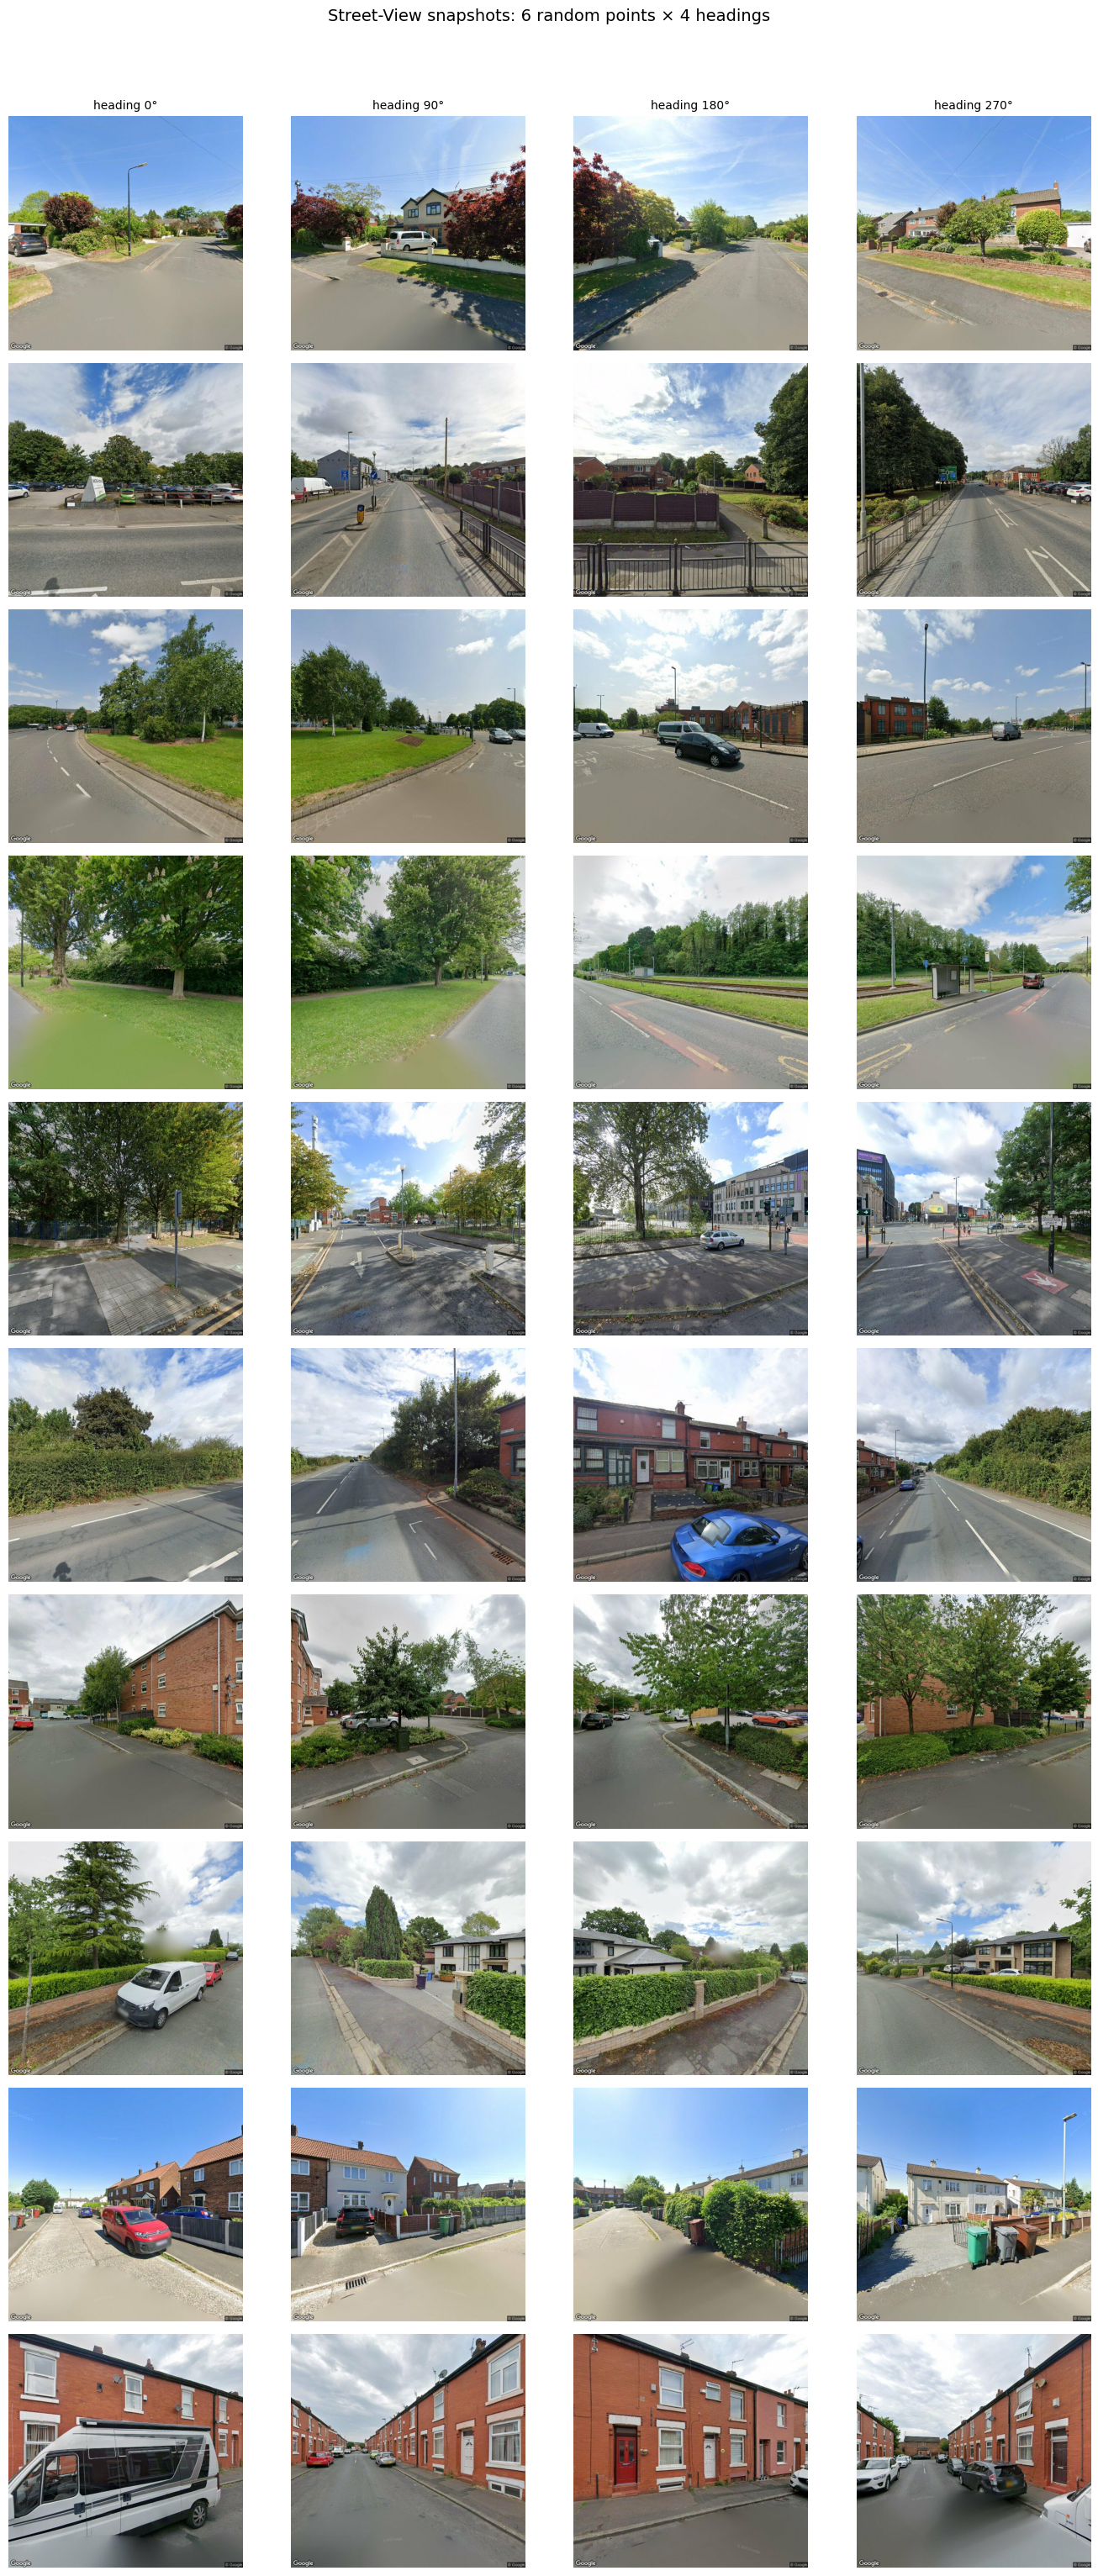

In [21]:
n_points_to_show =10          # rows
headings_per_pt  = n_directions   # columns; assumption: same for all points

# -------------------------------------------------------
# SAMPLE POINTS
# -------------------------------------------------------
# point_records was created earlier when you downloaded images
valid_records = [rec for rec in point_records if rec.get("image_files")]
if len(valid_records) < n_points_to_show:
    raise ValueError(f"Need at least {n_points_to_show} points with images; "
                     f"found {len(valid_records)}")

sample_pts = random.sample(valid_records, n_points_to_show)

# -------------------------------------------------------
# PLOT
# -------------------------------------------------------
fig, axes = plt.subplots(n_points_to_show,
                         headings_per_pt,
                         figsize=(headings_per_pt * 3.5, n_points_to_show * 3))

for row, rec in enumerate(sample_pts):
    imgs = rec["image_files"]
    # If fewer than expected headings (e.g. download failure), pad with blanks
    while len(imgs) < headings_per_pt:
        imgs.append(None)

    for col, img_path in enumerate(imgs[:headings_per_pt]):
        ax = axes[row, col] if n_points_to_show > 1 else axes[col]
        img_path = img_path.replace("airbnb-manchester/", "embeddings/")
        img_path = img_path.replace("../", "../../../../")
        if img_path and os.path.exists(img_path):
            ax.imshow(Image.open(img_path))
        else:
            # blank panel if the image is missing
            ax.text(0.5, 0.5, "no image", ha="center", va="center")
        ax.axis("off")

        # column headers once at top
        if row == 0:
            ax.set_title(f"heading {col*360/headings_per_pt:.0f}°", fontsize=10, pad=6)

    # label the leftmost image with point info
    axes[row, 0].set_ylabel(
        f"point {rec['point_id']}\n({rec['latitude']:.3f}, {rec['longitude']:.3f})",
        fontsize=8, rotation=0, ha="right", va="center")

plt.suptitle("Street-View snapshots: 6 random points × 4 headings", y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
### Correcting incorrect path links

In [ ]:
# for record in point_records:
#     record["image_files"] = [
#         path.replace(
#             "../data/airbnb-manchester/",
#             "/nfs/a319/gy17m2a/INTEGRATE/llm/data/embeddings/"
#         )
#         for path in record["image_files"]
#     ]
    
# with open(points_data_cache, "wb") as f:
#         pickle.dump(point_records, f)